# Capstone Project - Prediction of Order Intakes

### Import all needed libraries

In [1]:
%pip install matplotlib
#%pip install seaborn
%pip install numpy
#%pip install prohet
%pip install pandas
%pip install sklearn
%pip install scipy
%pip install statsmodels


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in th

In [2]:
%pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from prophet import Prophet
#statistics
from scipy import stats
from scipy.stats import norm
from datetime import datetime, date
#time series library
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR

### Definition of helper functions

In [4]:
def interpolation(dataframe: pd.DataFrame, method: str, index_name:str='', order:int=None):
    
    interpolated = []

    if method == 'spline':
        if index_name == '':
            interpolated = dataframe.interpolate(method=method, order=order)
        else:
            interpolated = dataframe[index_name].interpolate(method=method, order=order)
    elif method == 'linear':
        if index_name == '':
            interpolated = dataframe.interpolate(method=method)
        else:
            interpolated = dataframe[index_name].interpolate(method=method)

    else:
        print("Keine gültige Methode.")

    return interpolated


def plot_line_graph(dataframe:pd.DataFrame, index_name:str, title:str, xlabel:str, ylabel:str, location_legend:str='', lower_xlim:int='', upper_xlim:int=''):
    
    fontweight = 'bold'
    fontsize_title = 16
    fontsize_label = 12
    
    dataframe[index_name].plot(figsize=(15, 4))
    plt.tick_params(axis='x', rotation=90)
            
    plt.title(title, fontsize=fontsize_title, fontweight=fontweight)
    plt.xlabel(xlabel, fontsize=fontsize_label, fontweight=fontweight)
    plt.ylabel(ylabel, fontsize=fontsize_label, fontweight=fontweight)
    #plt.legend(loc=location_legend)
    
    if lower_xlim != '' and upper_xlim != '':
        plt.xlim(lower_xlim, upper_xlim)
        
    plt.grid(True, alpha=0.6)
    plt.savefig(f'Line_Graph des Merkmals {index_name}.png')
    plt.show()


def plot_decomposition_time_series(dataframe:pd.DataFrame, index_name:str, period:int):

    components_of_time_series = sm.tsa.seasonal_decompose(dataframe[index_name], model='additive', period=period)
    trend = components_of_time_series.trend
    seasonal = components_of_time_series.seasonal
    residuals = components_of_time_series.resid
    
    fig = components_of_time_series.plot()
    plt.show()
    
   # return trend, seasonal, residuals
    

def plot_histogram_and_density(dataframe:pd.DataFrame, index_name:str, xlabel:str = 'Value', ylabel:str = 'Probability / Density'):

    fontweight='bold'
    fontsize_labels=11
    fontsize_density=13

    mean = np.mean(dataframe[index_name].to_numpy())
    std = np.std(dataframe[index_name].to_numpy())

    plt.hist(dataframe[index_name], bins=25, density=True)
    plt.xlabel(xlabel, fontweight=fontweight, fontsize=fontsize_labels)
    plt.ylabel('Probability / Density', fontweight=fontweight, fontsize=fontsize_labels)
    plt.grid(visible = True, alpha = 0.6)

    #xmin = 0.0, xmax = 1.0
    xmin, xmax = plt.xlim()
    
    #generates a sample from xmin to xmax with the length of 100
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, loc = mean, scale = std)
  
    plt.plot(x, p, 'k', linewidth=2)
    plt.title(r'$\mu= {:.2f}$ und $\sigma= {:.2f}$'.format(mean, std), fontweight=fontweight, fontsize=fontsize_density)
    #plt.savefig(f'Histogramm mit Dichte des Merkmals {index_name}.png')
    plt.show()


def plot_partial_autocorrelation(dataframe:pd.DataFrame, index_name:str, title:str, lower_xlim:int=0, upper_xlim:int=100, xlabel:str='Lag', ylabel:str='Autokorrelation', savefig:str = 'Autokorrelation.png'):
    
    fontweight = 'bold'
    fontsize_title = 14
    fontsize_label = 11
    
    plot_pacf(dataframe[index_name], lags=100)
    plt.title(title, fontsize=fontsize_title, fontweight=fontweight)
    plt.xlabel(xlabel, fontsize=fontsize_label, fontweight=fontweight)
    plt.ylabel(ylabel, fontsize=fontsize_label, fontweight=fontweight)
    plt.grid(True, alpha=0.6)
    plt.xlim(lower_xlim, upper_xlim)
    #plt.savefig(savefig)
    plt.show()


def percent_change(val):
   previous_v = val[:-1]
   last_v = val[-1]
   percent_change = (last_v - np.mean(previous_v)) /np.mean(previous_v)
   return percent_change


def outlier_replacement(feature):

    # Center the data so the mean is 0
    feature_outlier_centered = feature - feature.mean()
    # Calculate standard deviation
    std = feature.std()
    # Use the absolute value of each datapoint
    # to make it easier to find outliers
    outliers = np.abs(feature_outlier_centered) > (std * 3)
    # Replace outliers with the median value
    feature_outlier_fixed = feature_outlier_centered.copy() 
    feature_outlier_fixed[outliers] = np.nanmedian(feature_outlier_fixed)

    return feature_outlier_fixed

#https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
def adfuller_test(time_series, signif:float=0.05, name:str='', verbose:bool=False):
    
    """Perform ADFuller to test for Stationarity of given series and print report"""
    test = adfuller(time_series, autolag='AIC')
    
    #test[0] = test_statistic
    #test[1] = p_value
    #test[2] = number of chosen lags
    #test[3] = number of used observations
    #test[4] = critical values    
    
    output = {'test_statistic': round(test[0], 4), 
              'p_value': round(test[1], 4), 
              'num_lags': round(test[2], 4), 
              'num_observations': test[3]}
    
    p_value = output['p_value'] 

    # Print Summary
    print(f' Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["num_lags"]}')

    for key, value in test[4].items():
        print(f' Critical value {key} = {round(value, 3)}')

    # if probability is lower than level of significance (0.05)
    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

def plot_cross_correlation(dataframe1, dataframe2, start, ende, maxlags):
    
    fontweight = 'bold'
    fontsize_labels = 13
    fontsize_title = 13

    array = plt.xcorr(dataframe1, dataframe2, normed=True, maxlags=maxlags)
    plt.title(f'{dataframe1.name} über {dataframe2.name}', fontsize=fontsize_title, fontweight=fontweight)
    plt.xlabel('Lags (Woche)', fontsize=fontsize_labels, fontweight=fontweight)
    plt.ylabel('Korrelationskoeffizient (r)', fontsize=fontsize_labels, fontweight=fontweight)
    #plt.savefig(f'Kreuzkorrelation {dataframe1.name} über {dataframe2.name}.png')
    plt.show()


def get_statistical_values_of_feature(dataframe, index_name, window_size=4):
    
    mean = dataframe[index_name].rolling(window=window_size, center=True).mean()
    max_value = dataframe[index_name].rolling(window=window_size, center=True).max()
    min_value = dataframe[index_name].rolling(window=window_size, center=True).min()
    std_value = dataframe[index_name].rolling(window=window_size, center=True).std()
    median = dataframe[index_name].rolling(window=window_size, center=True).median()
    x25 = dataframe[index_name].rolling(window=window_size, center=True).quantile(0.25)
    x75 = dataframe[index_name].rolling(window=window_size, center=True).quantile(0.75)
    
    max_value_df = pd.DataFrame(data=max_value)
    max_value_df = max_value_df.rename(columns={index_name: f'{index_name}_max_rolling_{window_size}'})
    
    min_value_df = pd.DataFrame(data=min_value)
    min_value_df = min_value_df.rename(columns={index_name: f'{index_name}_min_rolling_{window_size}'})
    
    std_value_df = pd.DataFrame(data=std_value)
    std_value_df = std_value_df.rename(columns={index_name: f'{index_name}_std_rolling_{window_size}'})
    
    median_df = pd.DataFrame(data=median)
    median_df = median_df.rename(columns={index_name: f'{index_name}_median_rolling_{window_size}'})
    
    x25_df = pd.DataFrame(data=x25)
    x25_df = x25_df.rename(columns={index_name: f'{index_name}_first_quantile_rolling_{window_size}'})
    
    x75_df = pd.DataFrame(data=x75)
    x75_df = x75_df.rename(columns={index_name: f'{index_name}_third_quantile_rolling_{window_size}'})
    
    df_statistical_values = pd.concat([max_value_df, min_value_df, std_value_df, median_df], axis=1)
    
    return df_statistical_values



# Calculate MAE and RMSE
def evaluate_prediction(actual, predictions):
     
    errors = actual - predictions
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors)/actual) * 100
    median_absolute_percentage_error = np.median(np.abs(errors)/actual) * 100

    print('Mean Absolute Error: {:.2f}'.format(mae))
    print('Mean Absolute Percentage Error: {:.2f}%'.format(mape))
    print('Mean Squared Error: {:.2f}'.format(mse))
    print('Root Mean Squared Error: {:.2f}'.format(rmse))
    print('')
    print('')


def invert_differencing(test_orig, test_forecast, num_observations):
    
    # 1.
    # get last value of non-stationary train_data test_non_stationary[column].iloc[-1] 
    # due to the fact that train_test_split cuts of the previous value for inversing

    # 2.
    # cumsum = return the cumulative sum of the elements along a given axis
    # cumuate the sum of each column --> for each loop through columns and add the last non-stationary value of training_data
    
    
    #getting last value of test data for invert differencing test data
    x = pd.DataFrame(data=test_orig.iloc[-num_observations]).T
    x_diff = test_forecast.copy()

    #concat two dataframes on axis
    #cumsum = return the cumulative sum of the elements along a given axis
    inverse = pd.concat([x, x_diff]).cumsum().reset_index()
    inverse = inverse.drop(columns=['index'])
    
    return inverse


def plot_multiple_line_graphs(dataframe1:pd.DataFrame, dataframe2: pd.DataFrame):

    df = pd.concat([dataframe1, dataframe2], axis=1)
    df.iloc[:, :2].plot(figsize=(15, 4)) 

def month_to_datestring(month: int):
    # Startpunkt Januar 2000
    m = (month - 1) % 12 + 1
    m_string = str(m) if m > 9 else '0' + str(m)
    y = (month-1) // 12
    y_string = str(y) if y > 9 else '0' + str(y)
    
    return f'{m_string}/{y_string}'

def convert_month_to_date(df: pd.DataFrame):
    df['date'] = df['month'].apply(month_to_datestring)
    df['date'] = pd.to_datetime(df['date'], format='%m/%y')
    result = df.set_index('date').drop(['month'], axis=1)
    result.index = pd.DatetimeIndex(result.index).to_period('M')

    return result.sort_index()

def remove_future_rows(df: pd.DataFrame) -> pd.DataFrame:
    return df[:258].copy()

def grangers_causation_matrix(data, variables, maxlag, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var for var in variables]
    df.index = [var for var in variables]
    return df

## Data Preprocessing

In [5]:
df = pd.read_csv('kitCapstoneJan24_data.csv', delimiter=';')
df_converted = convert_month_to_date(df)
df_converted = df_converted[df_converted['countryname'] == 'Country A'].copy()
df_converted = remove_future_rows(df_converted)

In [6]:
white_list_global_consumer = ['global_consumer__unemployment_rate', 'global_consumer__total_population', 'global_consumer__total_consumption', 'global_consumer__financial_other_services', 'global_consumer__average_income', 'global_consumer__automobiles']
white_list_global_economy = ['global_economy__bop_basic_balance_euro__euro', 'global_economy__bop_goods_balance_of_gdp__percentage', 'global_economy__bop_goods_exports_euro__euro', 'global_economy__bop_goods_imports_euro__euro', 'global_consumer__consumer_price_index']
porsche_vg1_cols = [col for col in df_converted.columns if 'vehiclegroup01' in col]
#for entry in white_list_global_consumer:
#    porsche_vg1_cols.append(entry)
#for entry in white_list_global_economy:
#    porsche_vg1_cols.append(entry)

porsche_df = df_converted[porsche_vg1_cols]

In [7]:
porsche_df = interpolation(porsche_df, method='linear')
porsche_df.fillna(0, inplace=True)

## Explorative Data Analysis

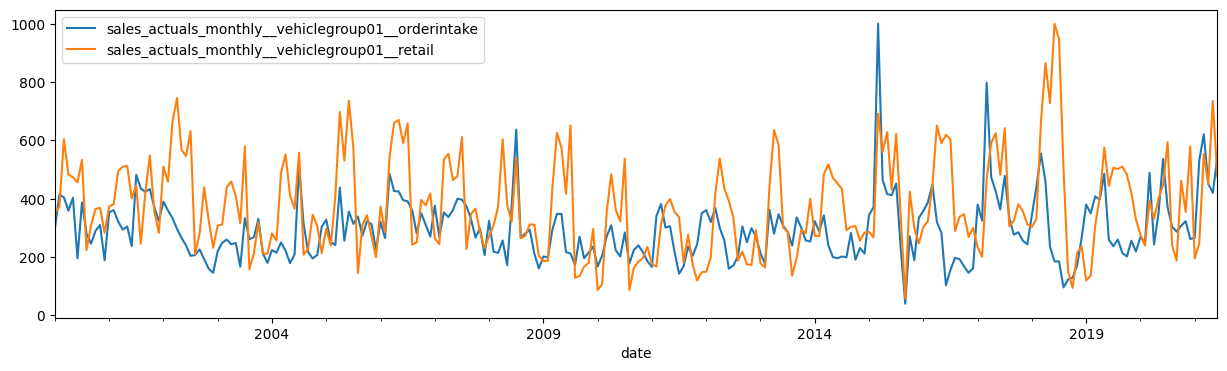

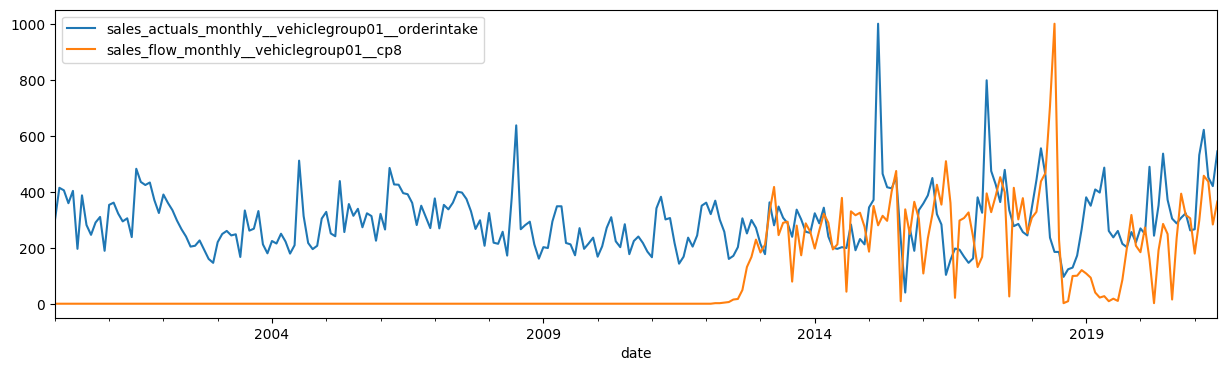

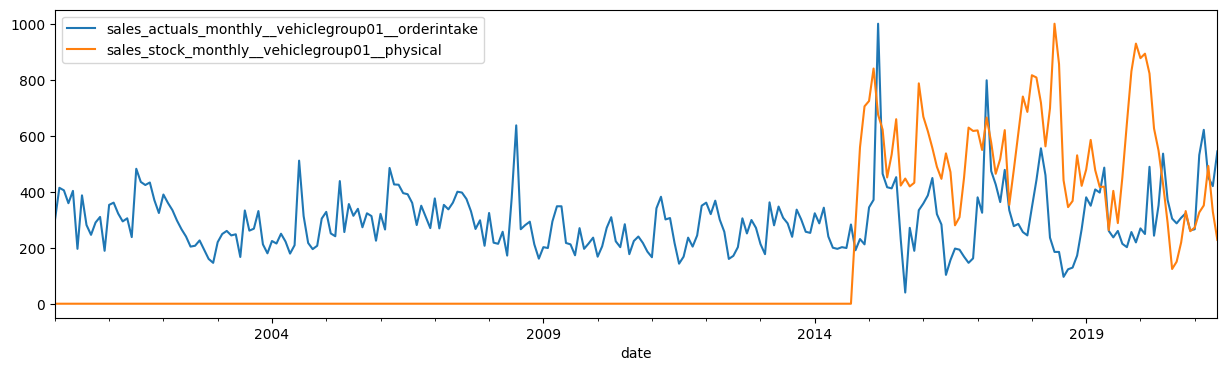

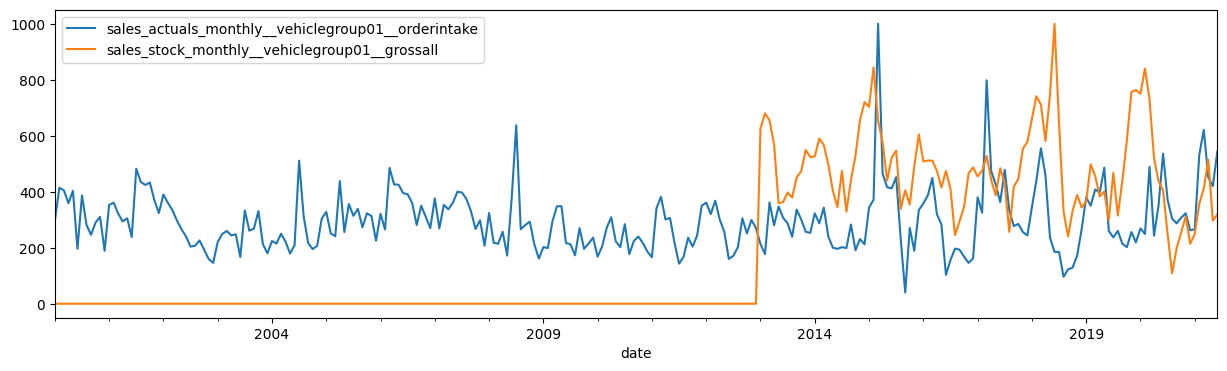

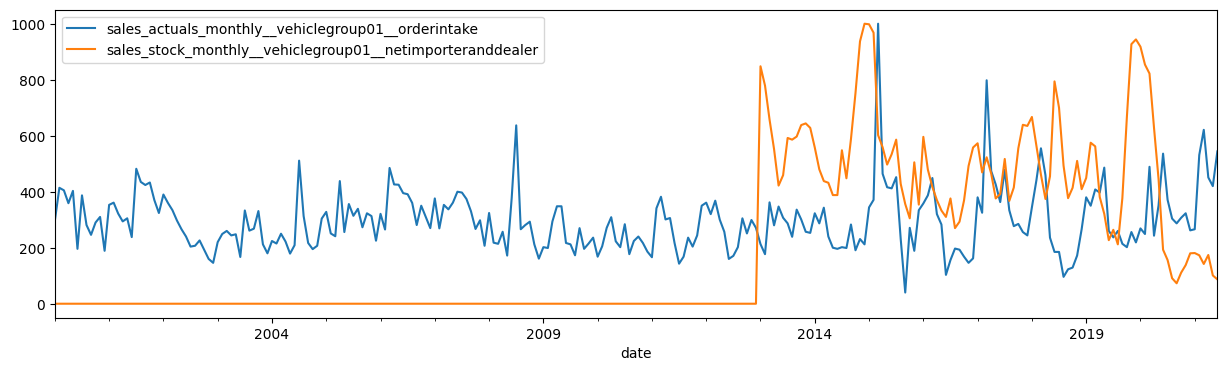

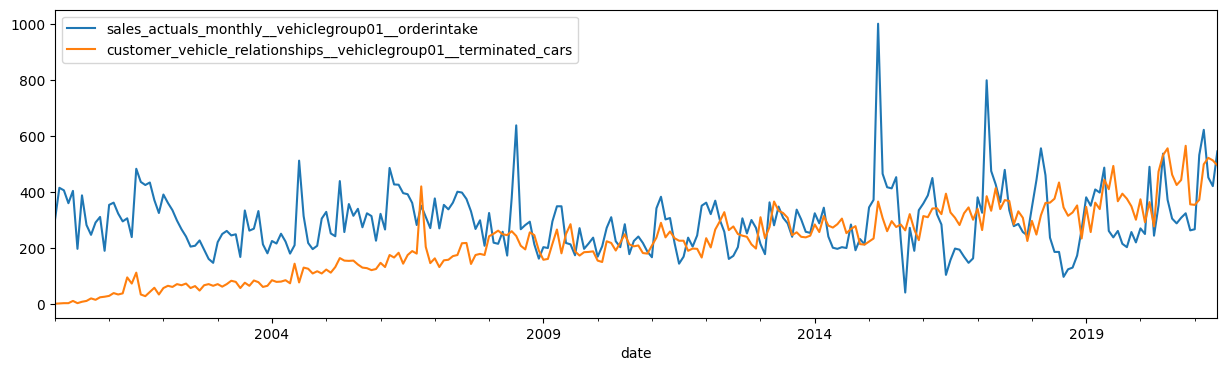

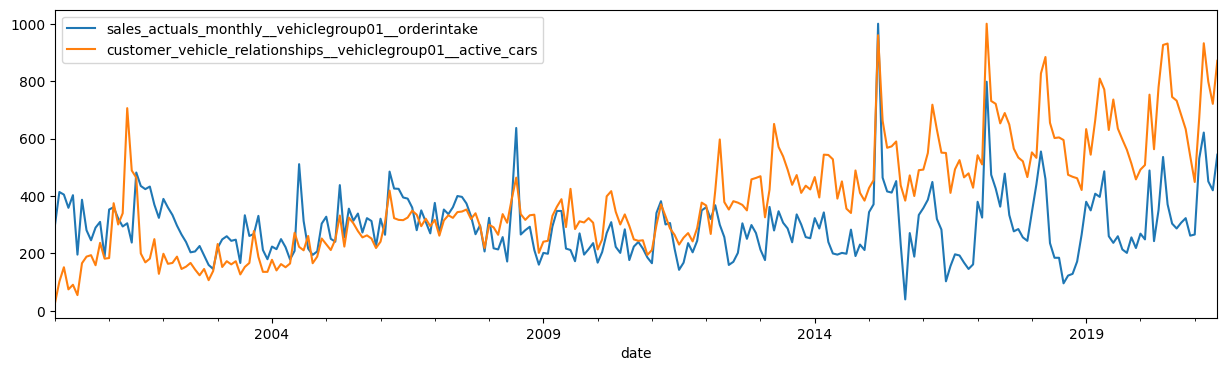

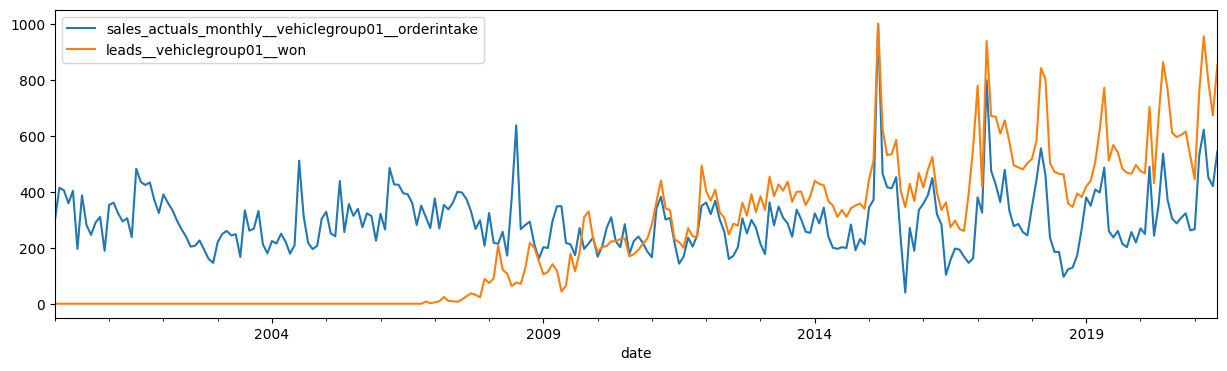

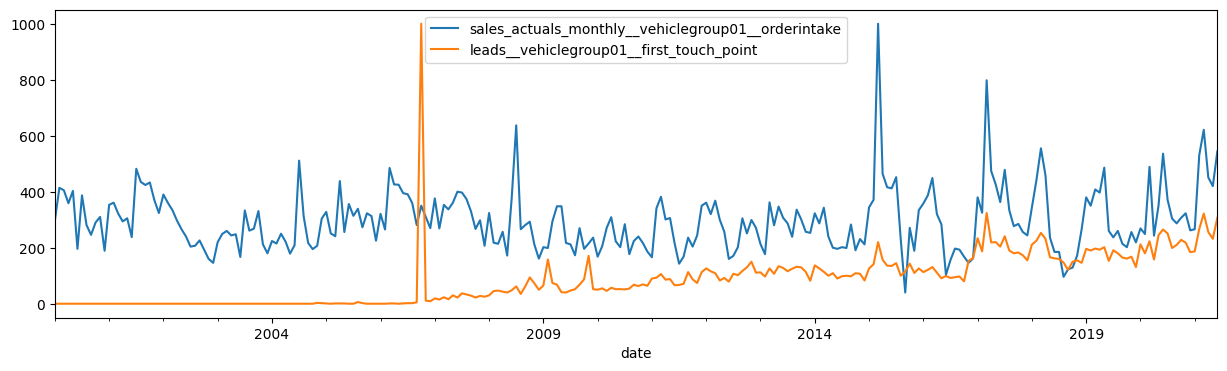

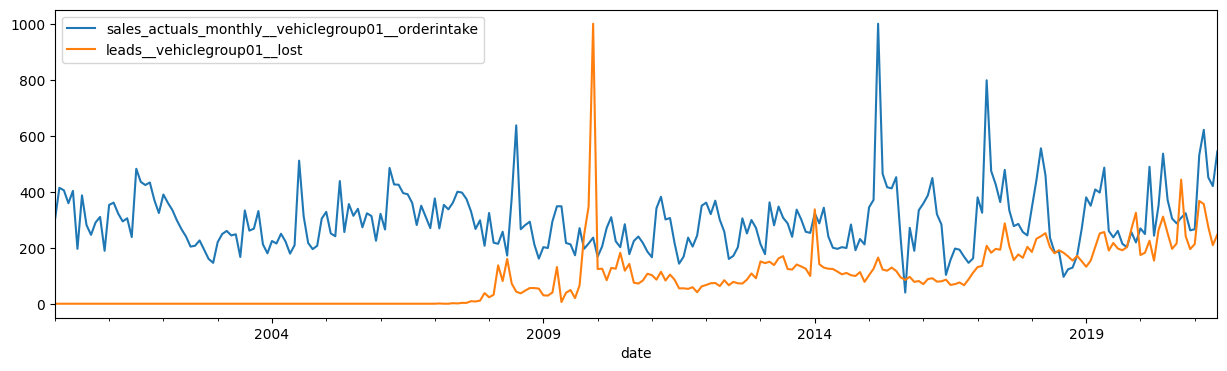

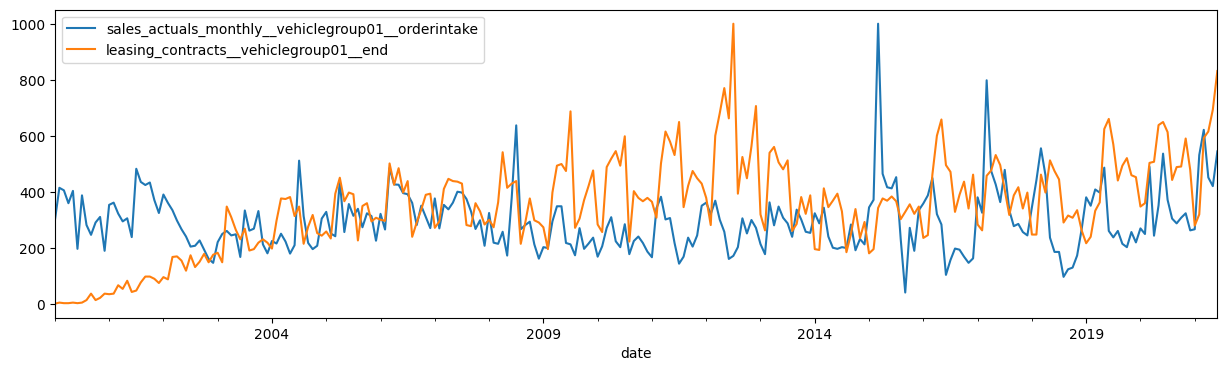

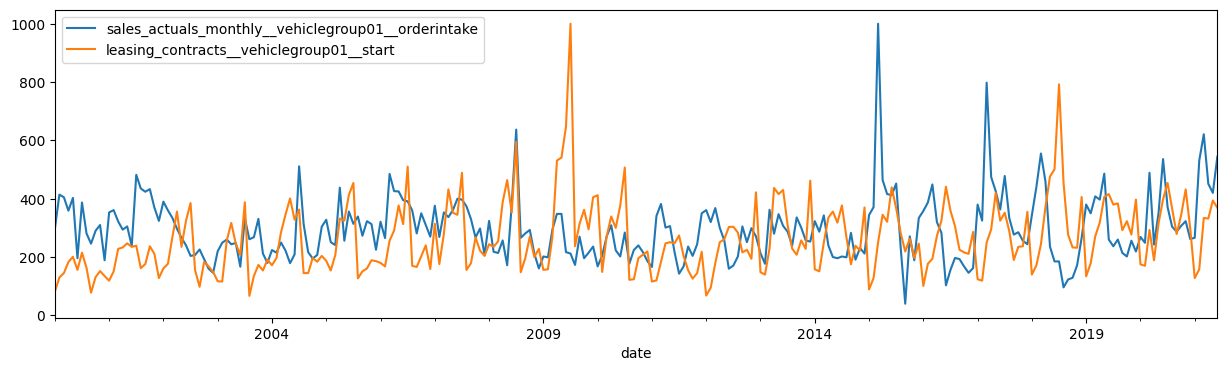

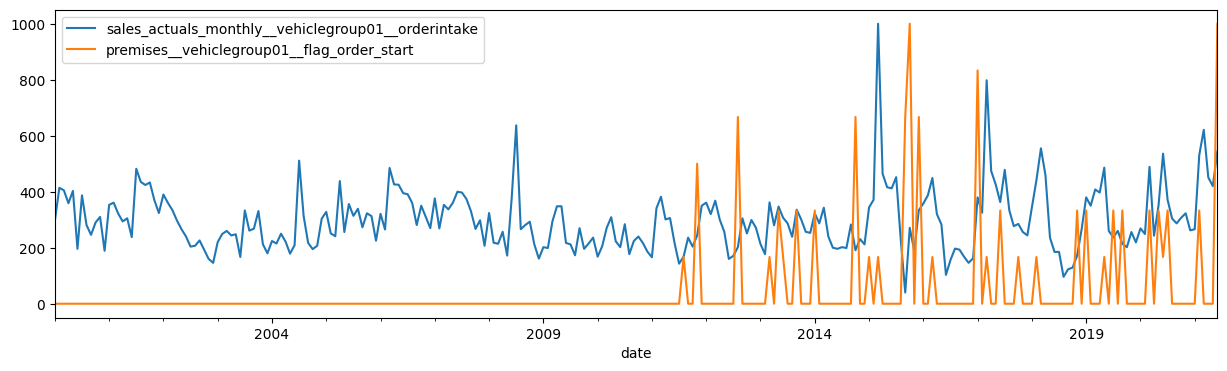

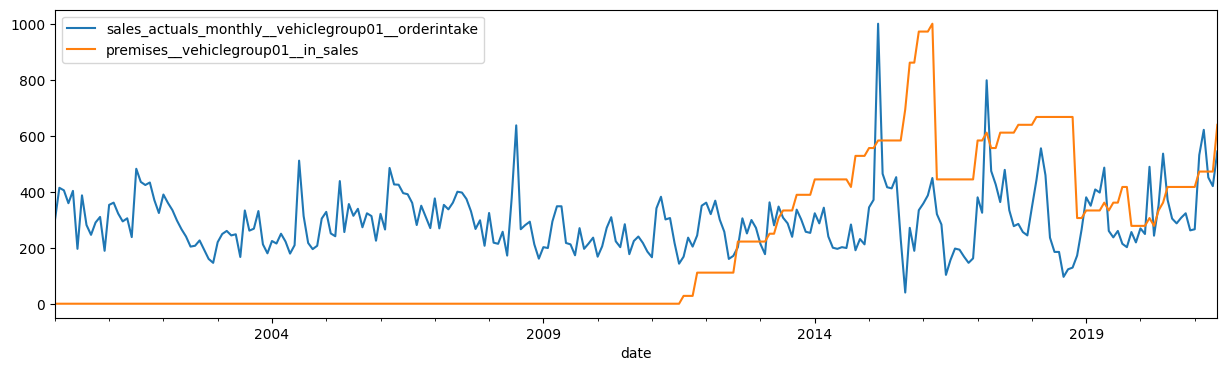

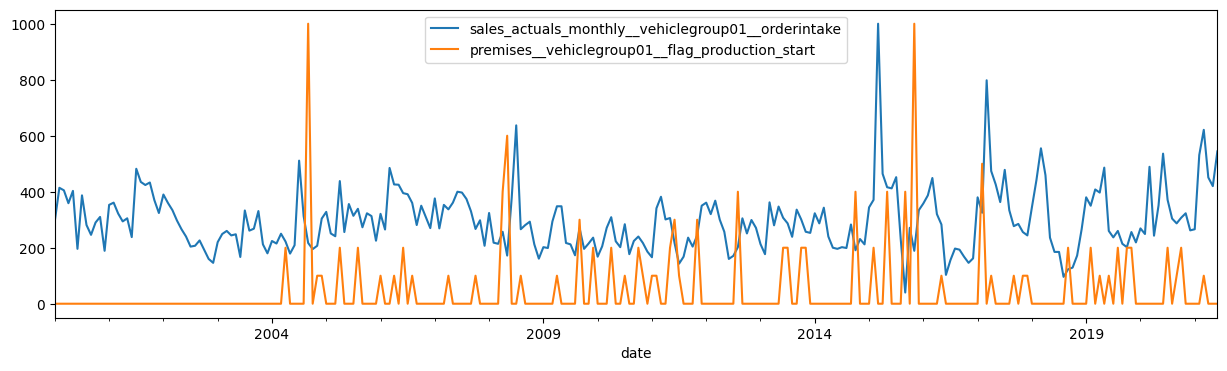

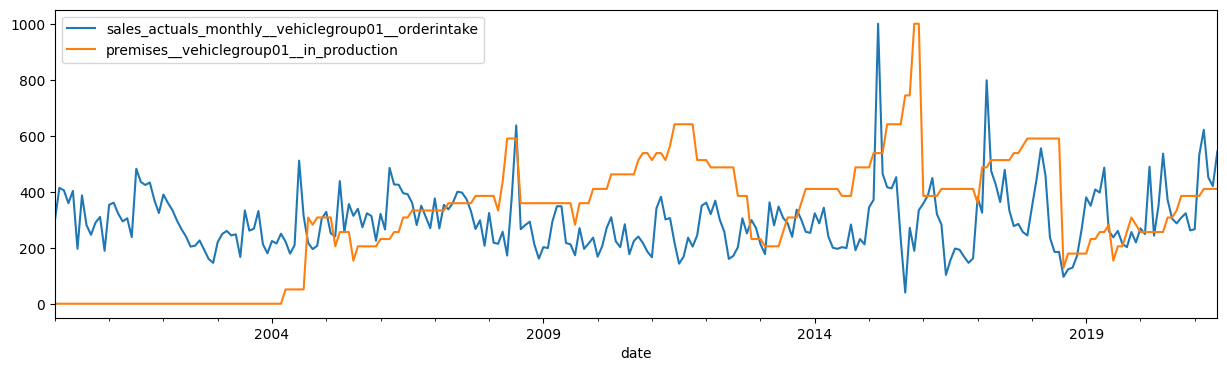

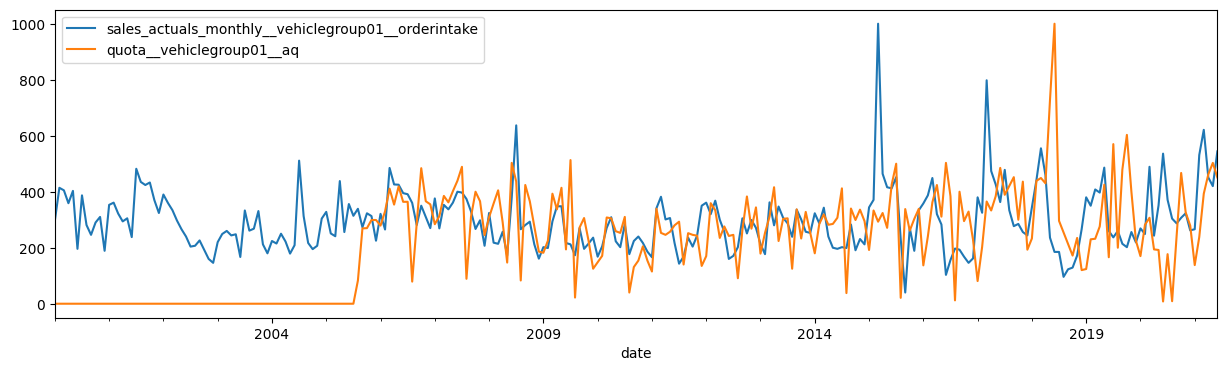

In [8]:
df1 = porsche_df.iloc[:, 0]

for column in porsche_df.columns:
    if not 'orderintake' in column:
        plot_multiple_line_graphs(df1, porsche_df[column])

### Check Correlations

In [9]:
#iterate through time series
for name, column in porsche_df.items():
    
    #apply the augmented dickey fuller test for checking the stationarity of time series
    #if time series are stationary, the cross-correlation check can be done
    adfuller_test(column, name=column.name)
    print('\n')

 Augmented Dickey-Fuller Test on "sales_actuals_monthly__vehiclegroup01__orderintake" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1204
 No. Lags Chosen       = 12
 Critical value 1% = -3.457
 Critical value 5% = -2.873
 Critical value 10% = -2.573
 => P-Value = 0.0251. Rejecting Null Hypothesis.
 => Series is Stationary.


 Augmented Dickey-Fuller Test on "sales_actuals_monthly__vehiclegroup01__retail" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.3216
 No. Lags Chosen       = 12
 Critical value 1% = -3.457
 Critical value 5% = -2.873
 Critical value 10% = -2.573
 => P-Value = 0.1651. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


 Augmented Dickey-Fuller Test on "sales_flow_monthly__vehiclegroup01__cp8" 
    -----------

In [10]:
#shift time series with first lag => shifted = t - t-1
porsche_df_shifted = porsche_df.diff().dropna()

porsche_df_shifted.tail()

,sales_actuals_monthly__vehiclegroup01__orderintake,sales_actuals_monthly__vehiclegroup01__retail,sales_flow_monthly__vehiclegroup01__cp8,sales_stock_monthly__vehiclegroup01__physical,sales_stock_monthly__vehiclegroup01__grossall,sales_stock_monthly__vehiclegroup01__netimporteranddealer,customer_vehicle_relationships__vehiclegroup01__terminated_cars,customer_vehicle_relationships__vehiclegroup01__active_cars,leads__vehiclegroup01__won,leads__vehiclegroup01__first_touch_point,leads__vehiclegroup01__lost,leasing_contracts__vehiclegroup01__end,leasing_contracts__vehiclegroup01__start,premises__vehiclegroup01__flag_order_start,premises__vehiclegroup01__in_sales,premises__vehiclegroup01__flag_production_start,premises__vehiclegroup01__in_production,quota__vehiclegroup01__aq
date,,,,,,,,,,,,,,,,,,
2021-02,265.0,52.0,118.0,54.0,108.0,-8.0,18.0,224.0,312.0,80.0,154.0,40.0,30.0,333.0,55.0,0.0,0.0,100.0
2021-03,90.0,306.0,160.0,25.0,54.0,-31.0,127.0,259.0,198.0,55.0,-11.0,273.0,176.0,-333.0,0.0,100.0,25.0,155.0
2021-04,-170.0,-103.0,-21.0,141.0,103.0,32.0,23.0,-134.0,-161.0,-66.0,-82.0,23.0,-2.0,0.0,0.0,-100.0,0.0,69.0
2021-05,-31.0,285.0,-153.0,-163.0,-217.0,-73.0,-9.0,-77.0,-121.0,-24.0,-65.0,78.0,62.0,0.0,0.0,0.0,0.0,41.0
2021-06,124.0,-260.0,82.0,-101.0,22.0,-14.0,-18.0,150.0,180.0,75.0,38.0,138.0,-25.0,1000.0,167.0,0.0,0.0,-52.0


In [11]:
#iterate through time series
for name, column in porsche_df_shifted.items():
    
    #apply the augmented dickey fuller test for checking the stationarity of time series
    #if time series are stationary, the cross-correlation check can be done
    adfuller_test(column, name=column.name)
    print('\n')

 Augmented Dickey-Fuller Test on "sales_actuals_monthly__vehiclegroup01__orderintake" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.7685
 No. Lags Chosen       = 10
 Critical value 1% = -3.457
 Critical value 5% = -2.873
 Critical value 10% = -2.573
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 Augmented Dickey-Fuller Test on "sales_actuals_monthly__vehiclegroup01__retail" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.9224
 No. Lags Chosen       = 11
 Critical value 1% = -3.457
 Critical value 5% = -2.873
 Critical value 10% = -2.573
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 Augmented Dickey-Fuller Test on "sales_flow_monthly__vehiclegroup01__cp8" 
    ---------------------------------------

 Augmented Dickey-Fuller Test on "leads__vehiclegroup01__first_touch_point" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.6858
 No. Lags Chosen       = 8
 Critical value 1% = -3.457
 Critical value 5% = -2.873
 Critical value 10% = -2.573
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 Augmented Dickey-Fuller Test on "leads__vehiclegroup01__lost" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.9842
 No. Lags Chosen       = 6
 Critical value 1% = -3.457
 Critical value 5% = -2.873
 Critical value 10% = -2.573
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 Augmented Dickey-Fuller Test on "leasing_contracts__vehiclegroup01__end" 
    -----------------------------------------------
 Null Hypothesis: Data

__________________________________________________________________________________________


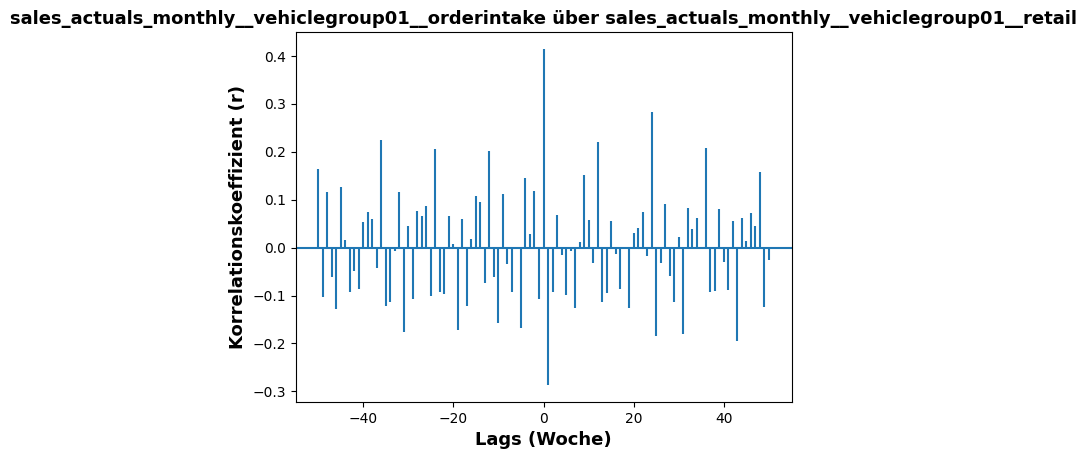

__________________________________________________________________________________________


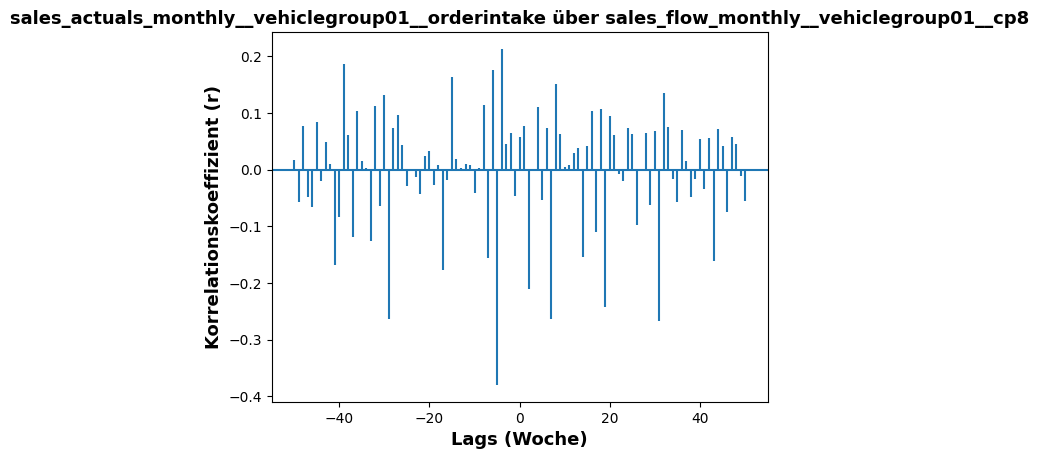

__________________________________________________________________________________________


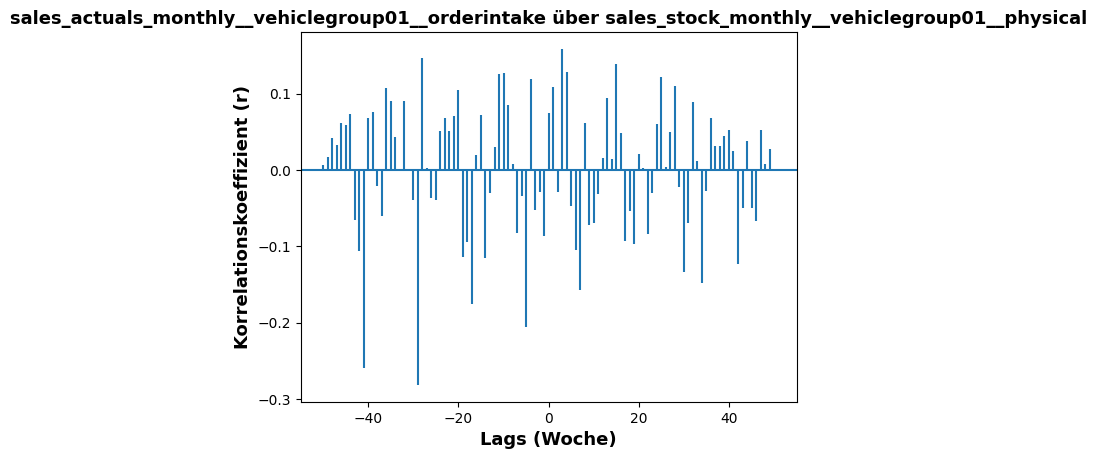

__________________________________________________________________________________________


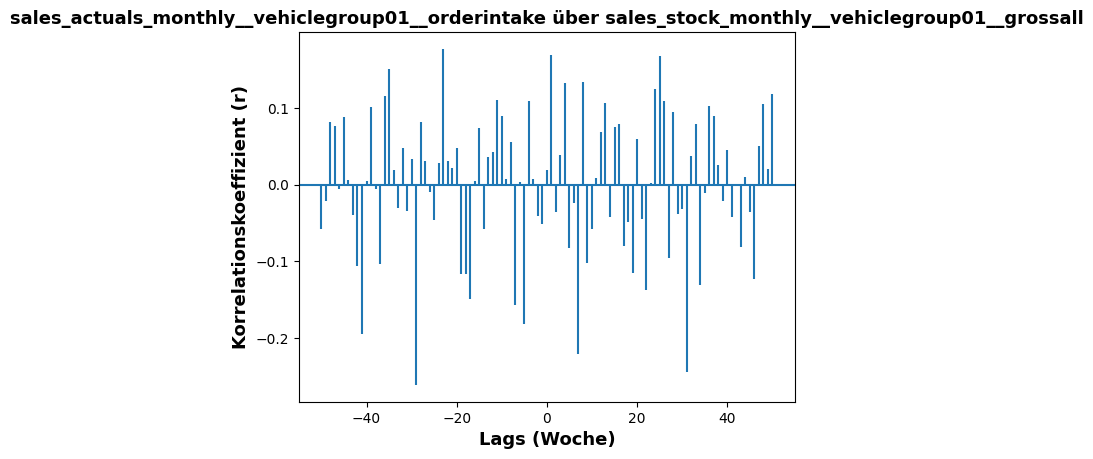

__________________________________________________________________________________________


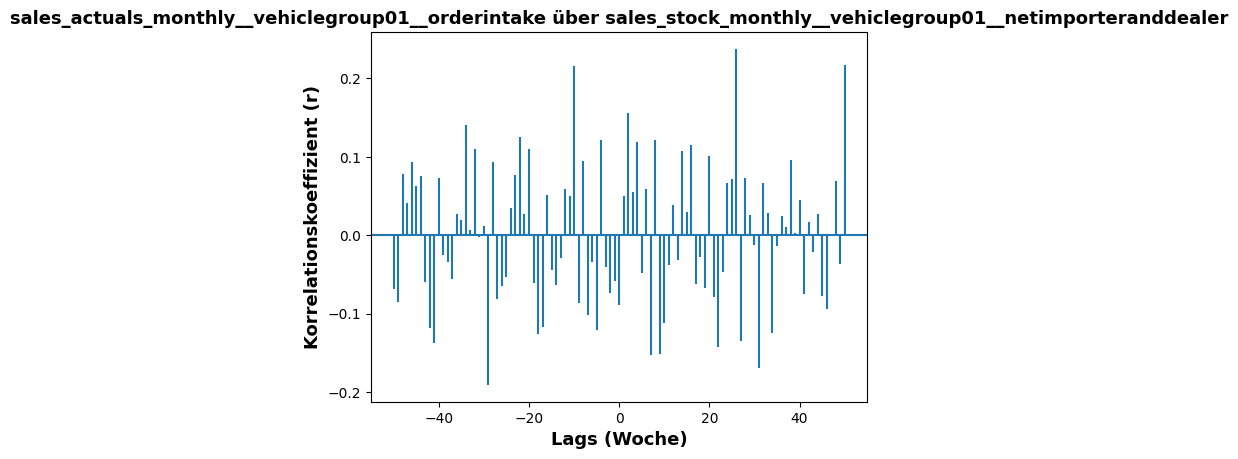

__________________________________________________________________________________________


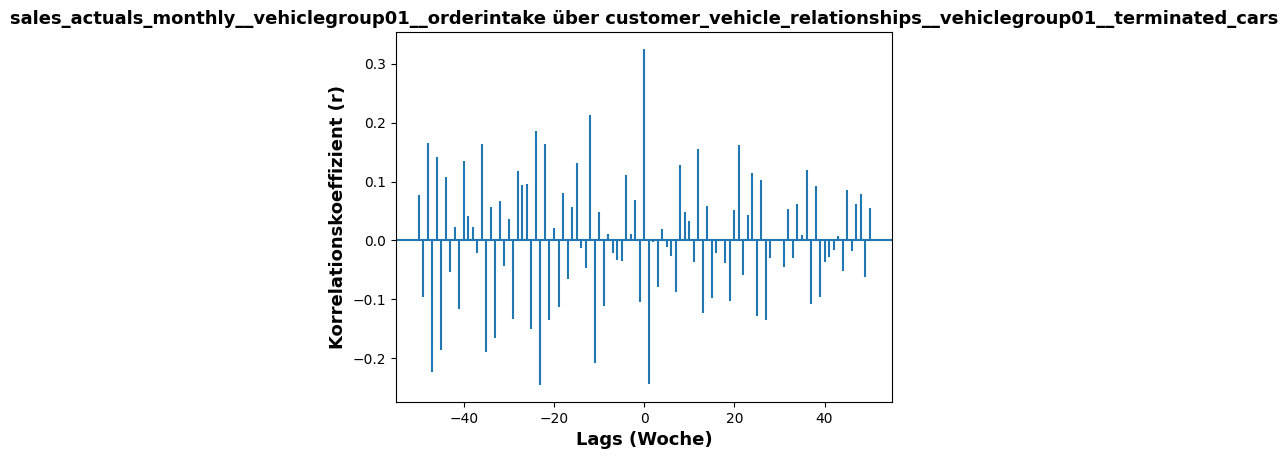

__________________________________________________________________________________________


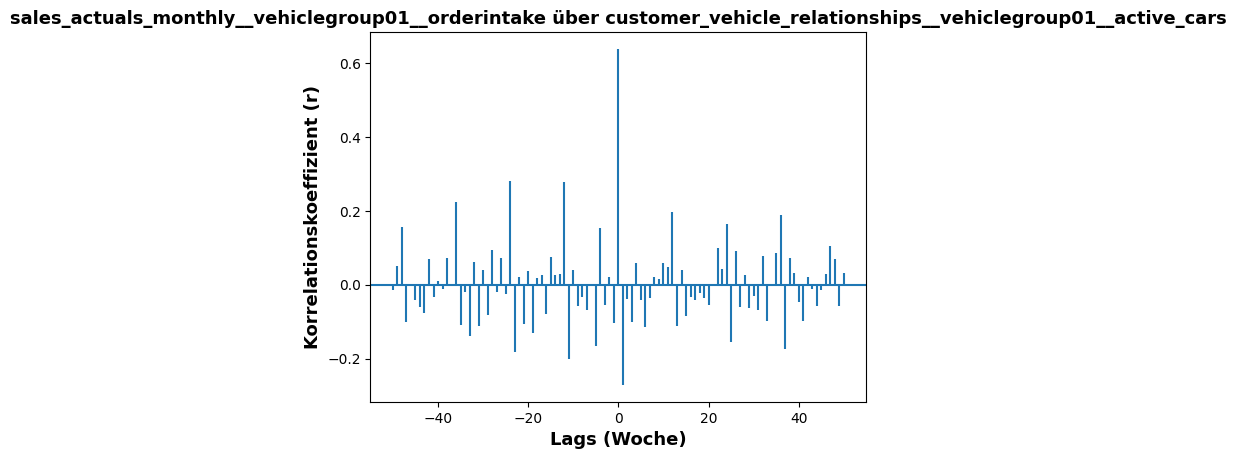

__________________________________________________________________________________________


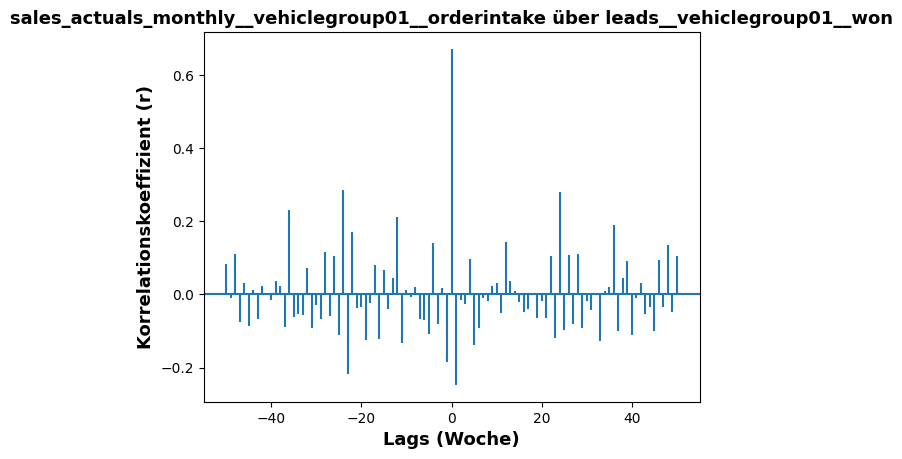

__________________________________________________________________________________________


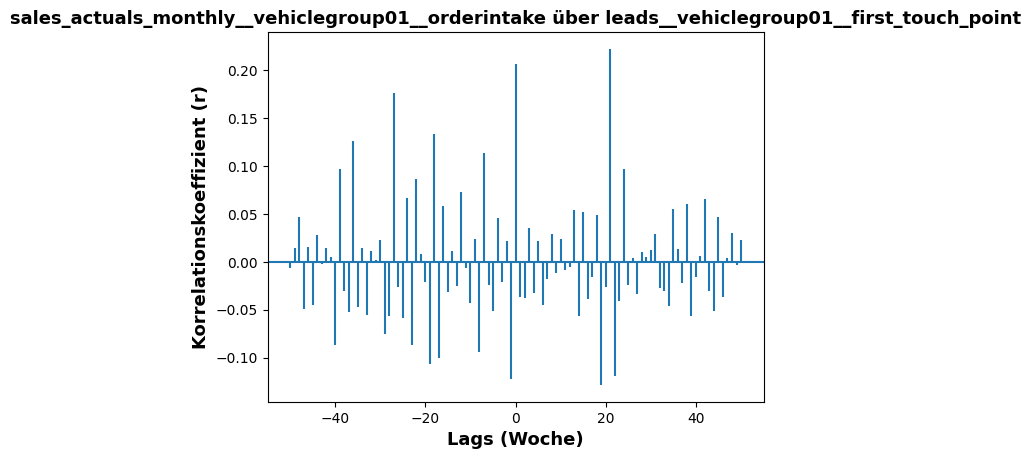

__________________________________________________________________________________________


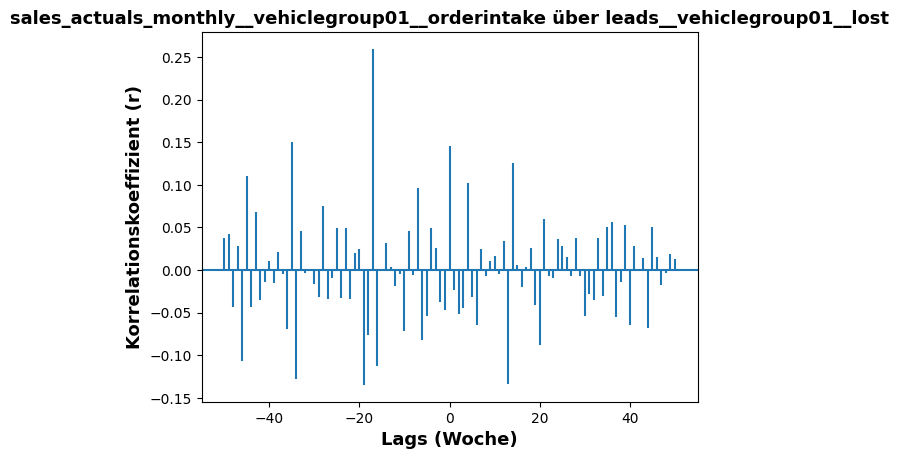

__________________________________________________________________________________________


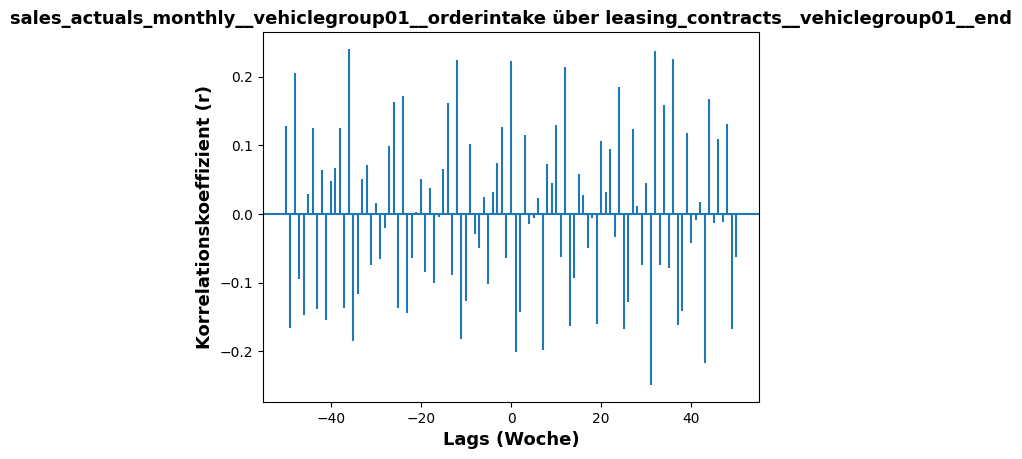

__________________________________________________________________________________________


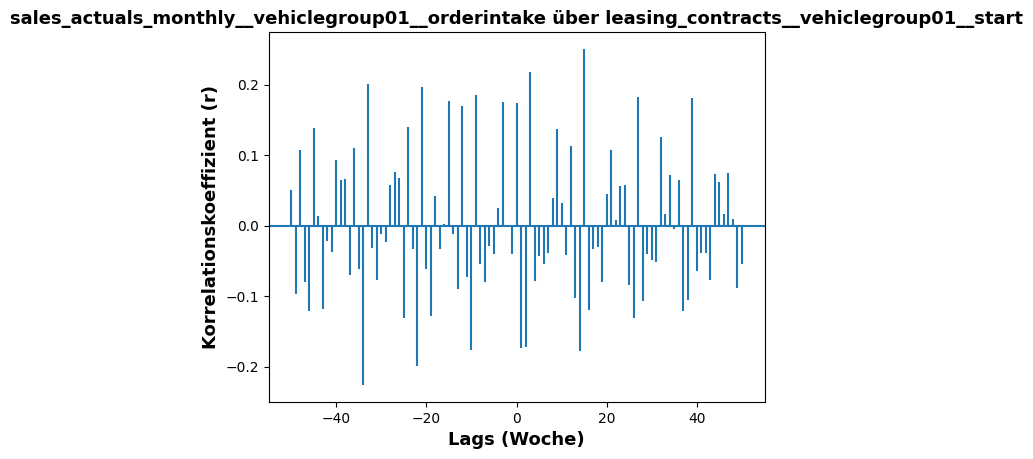

__________________________________________________________________________________________


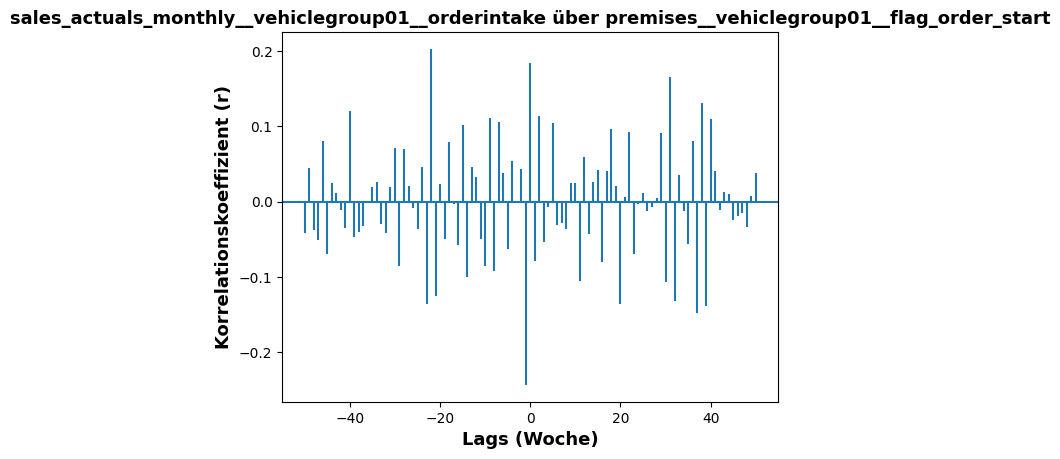

__________________________________________________________________________________________


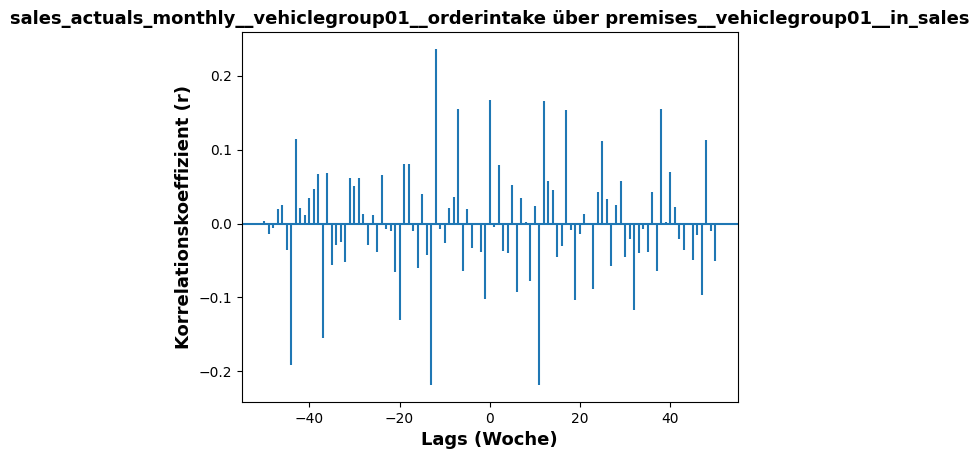

__________________________________________________________________________________________


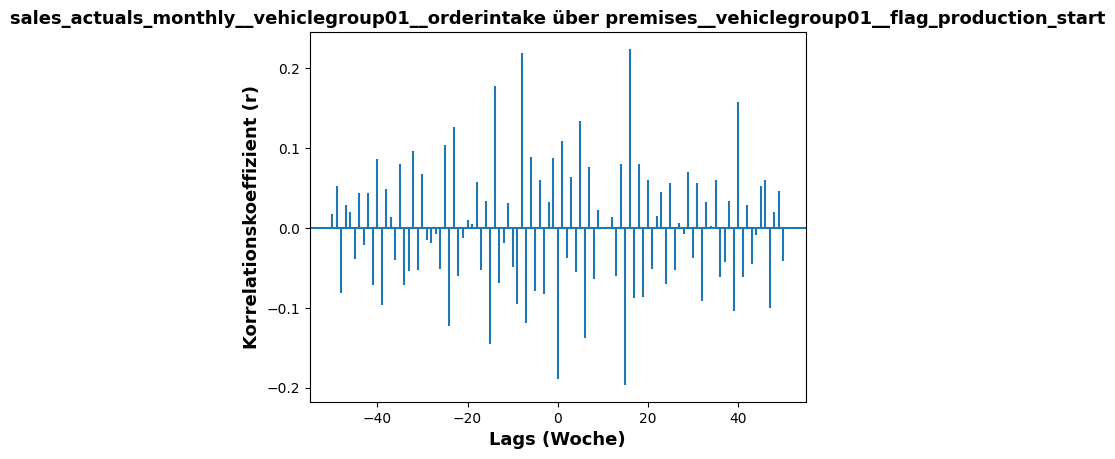

__________________________________________________________________________________________


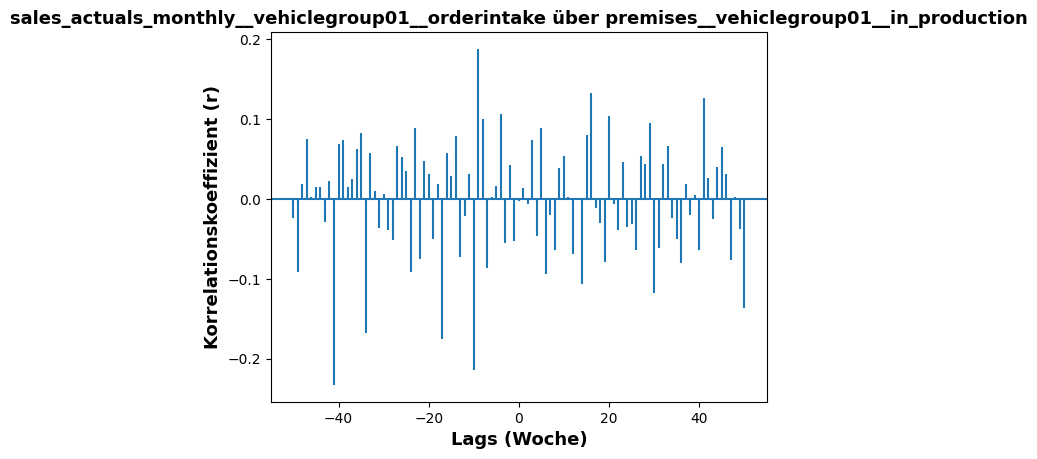

__________________________________________________________________________________________


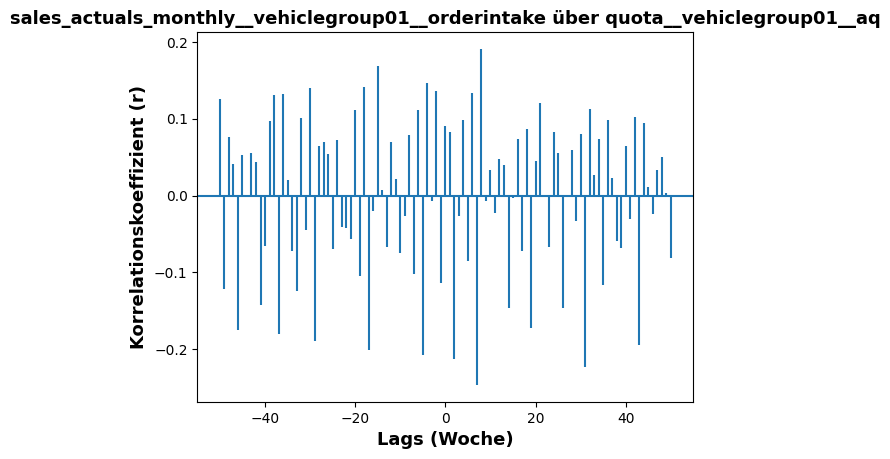

In [12]:
start = date(2000, 1, 1)
ende = date(2020, 12, 31)

#iteration through stationary time series
for i in range(porsche_df_shifted.shape[1]-1):
    
    print('__________________________________________________________________________________________')
    
    #plot cross correlation between input variables and target variable (=order intakes)
    plot_cross_correlation(porsche_df_shifted['sales_actuals_monthly__vehiclegroup01__orderintake'], porsche_df_shifted.iloc[:, i+1], start, ende, maxlags=50)

In [13]:
# compute correlations between internal data
df_vehiclegroup_corr = porsche_df.corr().sort_values(by=['sales_actuals_monthly__vehiclegroup01__orderintake'], ascending=False)
#only plot highest correlation
df_vehiclegroup_corr.head(15)

,sales_actuals_monthly__vehiclegroup01__orderintake,sales_actuals_monthly__vehiclegroup01__retail,sales_flow_monthly__vehiclegroup01__cp8,sales_stock_monthly__vehiclegroup01__physical,sales_stock_monthly__vehiclegroup01__grossall,sales_stock_monthly__vehiclegroup01__netimporteranddealer,customer_vehicle_relationships__vehiclegroup01__terminated_cars,customer_vehicle_relationships__vehiclegroup01__active_cars,leads__vehiclegroup01__won,leads__vehiclegroup01__first_touch_point,leads__vehiclegroup01__lost,leasing_contracts__vehiclegroup01__end,leasing_contracts__vehiclegroup01__start,premises__vehiclegroup01__flag_order_start,premises__vehiclegroup01__in_sales,premises__vehiclegroup01__flag_production_start,premises__vehiclegroup01__in_production,quota__vehiclegroup01__aq
sales_actuals_monthly__vehiclegroup01__orderintake,1.000000,0.365771,0.176692,0.187599,0.150404,0.061929,0.170988,0.439494,0.328008,0.257208,0.130787,0.062873,0.048989,0.115364,0.157552,-0.118856,0.045379,0.143202
customer_vehicle_relationships__vehiclegroup01__active_cars,0.439494,0.288698,0.660479,0.653790,0.687630,0.564230,0.863082,1.000000,0.877084,0.685529,0.636253,0.532812,0.347489,0.300011,0.730804,0.036771,0.438081,0.546985
sales_actuals_monthly__vehiclegroup01__retail,0.365771,1.000000,0.299236,0.180330,0.160147,0.053068,0.161207,0.288698,0.103183,0.048647,0.034364,0.256491,0.596253,-0.079137,0.129048,-0.092237,-0.031226,0.278430
leads__vehiclegroup01__won,0.328008,0.103183,0.695095,0.702677,0.756752,0.651722,0.853758,0.877084,1.000000,0.746656,0.737411,0.510043,0.205304,0.348967,0.792984,0.048655,0.540778,0.497517
leads__vehiclegroup01__first_touch_point,0.257208,0.048647,0.521031,0.547600,0.561894,0.478839,0.766276,0.685529,0.746656,1.000000,0.568718,0.402090,0.134630,0.277237,0.589860,0.024478,0.425446,0.476608
sales_stock_monthly__vehiclegroup01__physical,0.187599,0.180330,0.684508,1.000000,0.838012,0.777499,0.584760,0.653790,0.702677,0.547600,0.478283,0.202616,0.136486,0.238895,0.791113,0.040838,0.389121,0.407829
sales_flow_monthly__vehiclegroup01__cp8,0.176692,0.299236,1.000000,0.684508,0.823860,0.698395,0.607532,0.660479,0.695095,0.521031,0.481310,0.308215,0.218618,0.223216,0.782254,0.061599,0.442491,0.577502
customer_vehicle_relationships__vehiclegroup01__terminated_cars,0.170988,0.161207,0.607532,0.584760,0.635454,0.530125,1.000000,0.863082,0.853758,0.766276,0.669514,0.695667,0.389503,0.295566,0.680137,0.079737,0.580526,0.637563
premises__vehiclegroup01__in_sales,0.157552,0.129048,0.782254,0.791113,0.842645,0.766698,0.680137,0.730804,0.792984,0.589860,0.508298,0.251090,0.144671,0.369931,1.000000,0.108946,0.504603,0.439711
sales_stock_monthly__vehiclegroup01__grossall,0.150404,0.160147,0.823860,0.838012,1.000000,0.952071,0.635454,0.687630,0.756752,0.561894,0.537092,0.213045,0.144070,0.253149,0.842645,0.051464,0.387793,0.466189


In [14]:
#select features with a correlation higher than 0.15
df_vehiclegroup = porsche_df[df_vehiclegroup_corr[df_vehiclegroup_corr['sales_actuals_monthly__vehiclegroup01__orderintake'] >= 0.15].index]
df_vehiclegroup.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 258 entries, 2000-01 to 2021-06
Freq: M
Data columns (total 10 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   sales_actuals_monthly__vehiclegroup01__orderintake               258 non-null    float64
 1   customer_vehicle_relationships__vehiclegroup01__active_cars      258 non-null    float64
 2   sales_actuals_monthly__vehiclegroup01__retail                    258 non-null    float64
 3   leads__vehiclegroup01__won                                       258 non-null    float64
 4   leads__vehiclegroup01__first_touch_point                         258 non-null    float64
 5   sales_stock_monthly__vehiclegroup01__physical                    258 non-null    float64
 6   sales_flow_monthly__vehiclegroup01__cp8                          258 non-null    float64
 7   customer_vehicle_relation

### Splitting Dataset in Train and Test

In [15]:
#train_test_ratio = 0.3

split = 258-18
#split stationary data in training and test data
#train_var, test_var = train_test_split(df_shifted, test_size=train_test_ratio, shuffle=False)
train_var = df_vehiclegroup.iloc[0:split, :]
test_var = df_vehiclegroup.iloc[split:, :]
#get shape of splitted data
train_var.shape, test_var.shape

((240, 10), (18, 10))

### Differencing Time Series for Stationarity

In [16]:
#iterate through time series
for name, column in train_var.items():
    
    #apply the augmented dickey fuller test for checking the stationarity of time series
    #if time series are stationary, the cross-correlation check can be done
    adfuller_test(column, name=column.name)
    print('\n')

 Augmented Dickey-Fuller Test on "sales_actuals_monthly__vehiclegroup01__orderintake" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.1224
 No. Lags Chosen       = 4
 Critical value 1% = -3.458
 Critical value 5% = -2.874
 Critical value 10% = -2.573
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 Augmented Dickey-Fuller Test on "customer_vehicle_relationships__vehiclegroup01__active_cars" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.6799
 No. Lags Chosen       = 13
 Critical value 1% = -3.46
 Critical value 5% = -2.874
 Critical value 10% = -2.574
 => P-Value = 0.8519. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


 Augmented Dickey-Fuller Test on "sales_actuals_monthly__vehiclegroup01__retail" 


In [17]:
#shift time series with first lag => shifted = t - t-1
train_var_shifted = train_var.diff().dropna()


In [18]:
#iterate through time series
for name, column in train_var_shifted.items():
    
    #apply the augmented dickey fuller test for checking the stationarity of time series
    #if time series are stationary, the cross-correlation check can be done
    adfuller_test(column, name=column.name)
    print('\n')


 Augmented Dickey-Fuller Test on "sales_actuals_monthly__vehiclegroup01__orderintake" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.0548
 No. Lags Chosen       = 11
 Critical value 1% = -3.459
 Critical value 5% = -2.874
 Critical value 10% = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 Augmented Dickey-Fuller Test on "customer_vehicle_relationships__vehiclegroup01__active_cars" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.8692
 No. Lags Chosen       = 12
 Critical value 1% = -3.46
 Critical value 5% = -2.874
 Critical value 10% = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 Augmented Dickey-Fuller Test on "sales_actuals_monthly__vehiclegroup01__retail" 
    --------------------

## Model definition VAR

* exogenous variable = "An exogenous variable is a variable that is not affected by other variables in the system." -> e.g. date

* endogenous variable = "endogenous variables have values that are determined by other variables in the system"

*(https://www.statisticshowto.com/endogenous-variable/)*

In [19]:
maxlag=15
test = 'ssr_chi2test'

granger_causality = grangers_causation_matrix(train_var_shifted, variables = train_var_shifted.columns, maxlag=maxlag)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since fu

In [20]:
granger_causality = pd.DataFrame(granger_causality['sales_actuals_monthly__vehiclegroup01__orderintake'])
# check if hypothesis is rejected -> significant level of 0.05 is exceeded
granger_causality.sort_values(by='sales_actuals_monthly__vehiclegroup01__orderintake', ascending=False)

,sales_actuals_monthly__vehiclegroup01__orderintake
sales_actuals_monthly__vehiclegroup01__orderintake,1.0000
leads__vehiclegroup01__won,0.6425
leads__vehiclegroup01__first_touch_point,0.5485
customer_vehicle_relationships__vehiclegroup01__terminated_cars,0.0049
sales_stock_monthly__vehiclegroup01__grossall,0.0036
customer_vehicle_relationships__vehiclegroup01__active_cars,0.0005
sales_stock_monthly__vehiclegroup01__physical,0.0000
sales_actuals_monthly__vehiclegroup01__retail,0.0000
sales_flow_monthly__vehiclegroup01__cp8,0.0000
premises__vehiclegroup01__in_sales,0.0000


In [21]:
# filter of feature names, which are not dependend with the order intakes
granger_causality_cleaned = granger_causality[(round(granger_causality['sales_actuals_monthly__vehiclegroup01__orderintake'],4) > 0.05) & (round(granger_causality['sales_actuals_monthly__vehiclegroup01__orderintake'],4) < 1)]
granger_causality_cleaned.sort_values(by="sales_actuals_monthly__vehiclegroup01__orderintake", ascending = False)


,sales_actuals_monthly__vehiclegroup01__orderintake
leads__vehiclegroup01__won,0.6425
leads__vehiclegroup01__first_touch_point,0.5485


In [22]:
# drop independent features
train_var_shifted.drop(columns= (col for col in train_var_shifted.columns if col in granger_causality_cleaned.index), inplace=True)

In [23]:
train_var_shifted.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 239 entries, 2000-02 to 2019-12
Freq: M
Data columns (total 8 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   sales_actuals_monthly__vehiclegroup01__orderintake               239 non-null    float64
 1   customer_vehicle_relationships__vehiclegroup01__active_cars      239 non-null    float64
 2   sales_actuals_monthly__vehiclegroup01__retail                    239 non-null    float64
 3   sales_stock_monthly__vehiclegroup01__physical                    239 non-null    float64
 4   sales_flow_monthly__vehiclegroup01__cp8                          239 non-null    float64
 5   customer_vehicle_relationships__vehiclegroup01__terminated_cars  239 non-null    float64
 6   premises__vehiclegroup01__in_sales                               239 non-null    float64
 7   sales_stock_monthly__vehic

In [24]:
#instantiation of model
var_ = VAR(train_var_shifted)

## Grid Search for best lag parameter

Best lag is where AIC is at minimum.

In [25]:
var_.select_order(8)

In [26]:
#training of vector autoregression model
result = var_.fit(maxlags=8)
#summary of training
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 01, Feb, 2024
Time:                     22:04:32
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    74.5823
Nobs:                     231.000    HQIC:                   69.9587
Log likelihood:          -9821.43    FPE:                1.20081e+29
AIC:                      66.8332    Det(Omega_mle):     1.65211e+28
--------------------------------------------------------------------
Results for equation sales_actuals_monthly__vehiclegroup01__orderintake
                                                                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------------------------------------------
const                                                                  

In [27]:
from statsmodels.stats.stattools import durbin_watson
# check autocorrelation of residuals
out = durbin_watson(result.resid)

for col, val in zip(train_var_shifted.columns, out):
    print(col, ':', round(val, 2))

sales_actuals_monthly__vehiclegroup01__orderintake : 2.03
customer_vehicle_relationships__vehiclegroup01__active_cars : 1.97
sales_actuals_monthly__vehiclegroup01__retail : 2.1
sales_stock_monthly__vehiclegroup01__physical : 1.89
sales_flow_monthly__vehiclegroup01__cp8 : 1.95
customer_vehicle_relationships__vehiclegroup01__terminated_cars : 1.99
premises__vehiclegroup01__in_sales : 2.08
sales_stock_monthly__vehiclegroup01__grossall : 1.93


=> no autocorrelation of the residuals, because value is approx. 2

In [28]:
# get the lag order of training
lag_order = result.k_ar
print(f'Lag: {lag_order}\n')

# get input data for forecasting -> training data with best lag
# look back of lstm = 10; look back of var = 51
forecast_input = train_var_shifted.values[-lag_order:]
print(f'Shape of training data for forecast: {forecast_input.shape}')
forecast_input

Lag: 8

Shape of training data for forecast: (8, 8)


array([[  89.,  -38.,  170.,    1.,    5.,  105.,   28.,   18.],
       [-226., -141., -131., -155.,  -18.,  -34.,  -28., -102.],
       [ -23.,  106.,   62.,  140.,    9.,   83.,   28.,  168.],
       [  23., -101.,   -4., -115.,   -8., -126.,    0., -152.],
       [ -46.,  -38.,    8.,  163.,   75.,   27.,   56.,  124.],
       [ -12.,  -36.,  -27.,  193.,  114.,  -18.,    0.,  145.],
       [  54.,  -48.,  -64.,  186.,  118.,  -27., -139.,  172.],
       [ -37.,  -55.,  -90.,   99., -110.,  -48.,    0.,    7.]])

In [29]:
# Forecast

#num_observations = how many steps should be forecasted
num_observations = len(test_var) -1
print(f'Number of Overservations: {num_observations}')

forecast = result.forecast(y=forecast_input, steps=num_observations)

#convert forecasted values to data frame
df_forecast = pd.DataFrame(forecast, index=train_var_shifted.index[-num_observations:], columns=train_var_shifted.columns)

Number of Overservations: 17


In [30]:
inverse_test = invert_differencing(test_var, df_forecast, num_observations)

In [31]:
test_plot = test_var.copy()
test_plot = test_plot.reset_index().drop(columns=['date'])

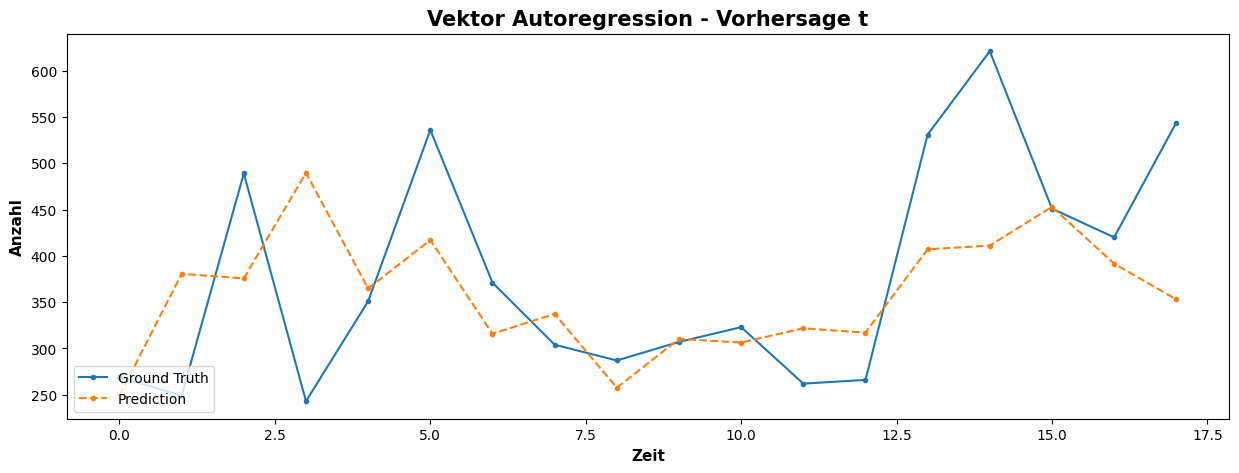

In [32]:
#plot_actual_vs_preds(test.iloc[:, 0], inverse_test.iloc[:, 0])

plt.figure(figsize=(15, 5))
plt.plot(test_plot.iloc[:, 0] ,label='Ground Truth', marker = '.')
plt.plot(inverse_test.iloc[:, 0], linestyle='dashed', label='Prediction', marker = '.')
plt.title('Vektor Autoregression - Vorhersage t', fontweight='bold', fontsize=15)
plt.xlabel('Zeit', fontsize=11, fontweight='bold')
plt.ylabel('Anzahl', fontsize=11, fontweight='bold')
plt.legend(loc='lower left')
#plt.xlim(0,100)
#plt.savefig(f'Forecast.png')
plt.show()

In [33]:
evaluate_prediction(actual=test_plot.iloc[:, 0], predictions=inverse_test.iloc[:, 0])

Mean Absolute Error: 80.45
Mean Absolute Percentage Error: 21.94%
Mean Squared Error: 11886.62
Root Mean Squared Error: 109.03




### Final Prediction with VAR'

In [34]:
#iterate through time series
for name, column in df_vehiclegroup.items():
    
    #apply the augmented dickey fuller test for checking the stationarity of time series
    #if time series are stationary, the cross-correlation check can be done
    adfuller_test(column, name=column.name)
    print('\n')

 Augmented Dickey-Fuller Test on "sales_actuals_monthly__vehiclegroup01__orderintake" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1204
 No. Lags Chosen       = 12
 Critical value 1% = -3.457
 Critical value 5% = -2.873
 Critical value 10% = -2.573
 => P-Value = 0.0251. Rejecting Null Hypothesis.
 => Series is Stationary.


 Augmented Dickey-Fuller Test on "customer_vehicle_relationships__vehiclegroup01__active_cars" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.2533
 No. Lags Chosen       = 12
 Critical value 1% = -3.457
 Critical value 5% = -2.873
 Critical value 10% = -2.573
 => P-Value = 0.9319. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


 Augmented Dickey-Fuller Test on "sales_actuals_monthly__vehiclegroup01__reta

In [35]:
#shift time series with first lag => shifted = t - t-1
df_vehiclegroup_shifted_ = train_var.diff().dropna()

In [36]:
#iterate through time series
for name, column in df_vehiclegroup_shifted_.items():
    
    #apply the augmented dickey fuller test for checking the stationarity of time series
    #if time series are stationary, the cross-correlation check can be done
    adfuller_test(column, name=column.name)
    print('\n')

 Augmented Dickey-Fuller Test on "sales_actuals_monthly__vehiclegroup01__orderintake" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.0548
 No. Lags Chosen       = 11
 Critical value 1% = -3.459
 Critical value 5% = -2.874
 Critical value 10% = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 Augmented Dickey-Fuller Test on "customer_vehicle_relationships__vehiclegroup01__active_cars" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.8692
 No. Lags Chosen       = 12
 Critical value 1% = -3.46
 Critical value 5% = -2.874
 Critical value 10% = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 Augmented Dickey-Fuller Test on "sales_actuals_monthly__vehiclegroup01__retail" 
    --------------------

In [37]:
df_vehiclegroup_shifted_.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 239 entries, 2000-02 to 2019-12
Freq: M
Data columns (total 10 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   sales_actuals_monthly__vehiclegroup01__orderintake               239 non-null    float64
 1   customer_vehicle_relationships__vehiclegroup01__active_cars      239 non-null    float64
 2   sales_actuals_monthly__vehiclegroup01__retail                    239 non-null    float64
 3   leads__vehiclegroup01__won                                       239 non-null    float64
 4   leads__vehiclegroup01__first_touch_point                         239 non-null    float64
 5   sales_stock_monthly__vehiclegroup01__physical                    239 non-null    float64
 6   sales_flow_monthly__vehiclegroup01__cp8                          239 non-null    float64
 7   customer_vehicle_relation

In [38]:
granger_causality_cleaned.index

Index(['leads__vehiclegroup01__won', 'leads__vehiclegroup01__first_touch_point'], dtype='object')

In [39]:
df_vehiclegroup_shifted_.drop(columns= (col for col in df_vehiclegroup_shifted_.columns if col in granger_causality_cleaned.index), inplace=True)
df_vehiclegroup_shifted_.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 239 entries, 2000-02 to 2019-12
Freq: M
Data columns (total 8 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   sales_actuals_monthly__vehiclegroup01__orderintake               239 non-null    float64
 1   customer_vehicle_relationships__vehiclegroup01__active_cars      239 non-null    float64
 2   sales_actuals_monthly__vehiclegroup01__retail                    239 non-null    float64
 3   sales_stock_monthly__vehiclegroup01__physical                    239 non-null    float64
 4   sales_flow_monthly__vehiclegroup01__cp8                          239 non-null    float64
 5   customer_vehicle_relationships__vehiclegroup01__terminated_cars  239 non-null    float64
 6   premises__vehiclegroup01__in_sales                               239 non-null    float64
 7   sales_stock_monthly__vehic

In [40]:
# look back of var = 11
forecast_input_final = df_vehiclegroup_shifted_.values[-lag_order:]
print(f'Shape of final data for forecast: {forecast_input_final.shape}')

Shape of final data for forecast: (8, 8)


In [41]:
# Forecast
print(f'Number of Overservations: {num_observations+1}')

forecast_final = result.forecast(y=forecast_input_final, steps=num_observations+1)

#convert forecasted values to data frame
df_forecast_final = pd.DataFrame(forecast, index=df_vehiclegroup_shifted_.index[-num_observations:], columns=df_vehiclegroup_shifted_.columns)


Number of Overservations: 18


In [42]:
df_forecast

,sales_actuals_monthly__vehiclegroup01__orderintake,customer_vehicle_relationships__vehiclegroup01__active_cars,sales_actuals_monthly__vehiclegroup01__retail,sales_stock_monthly__vehiclegroup01__physical,sales_flow_monthly__vehiclegroup01__cp8,customer_vehicle_relationships__vehiclegroup01__terminated_cars,premises__vehiclegroup01__in_sales,sales_stock_monthly__vehiclegroup01__grossall
date,,,,,,,,
2018-08,131.577063,117.676217,156.060574,-15.196374,5.403140,78.999551,-20.437428,65.258555
2018-09,-4.888533,22.378471,-119.843639,-80.207143,-25.432241,-46.163928,-41.255782,-21.817377
2018-10,113.986078,128.911337,218.533383,-30.014362,33.894437,73.121759,52.277636,-40.246789
2018-11,-124.934345,-27.732394,92.467421,-103.988618,13.020812,-4.349454,-88.910793,-96.128601
2018-12,52.312863,6.750946,45.122623,23.633659,45.163097,16.676344,35.088883,-44.191345
2019-01,-101.230491,-72.572258,-43.717023,18.734743,-62.659702,5.221403,58.844395,-32.900292
2019-02,21.545304,-22.454008,-8.675580,5.745631,-51.485502,2.261814,9.770952,3.892870
2019-03,-79.828820,-88.648937,-263.227158,-27.256572,-113.648152,-56.208214,52.049311,-32.291839
2019-04,52.755636,64.260515,18.454463,49.836593,91.038267,17.578170,15.122061,43.471672


In [43]:
x = pd.DataFrame(data=df_vehiclegroup.iloc[-1]).T
x_diff = df_forecast_final.copy()

    #concat two dataframes on axis
    #cumsum = return the cumulative sum of the elements along a given axis
inverse = pd.concat([x, x_diff]).cumsum().reset_index()
inverse = inverse.drop(columns=['index'])

inverse

,sales_actuals_monthly__vehiclegroup01__orderintake,customer_vehicle_relationships__vehiclegroup01__active_cars,sales_actuals_monthly__vehiclegroup01__retail,leads__vehiclegroup01__won,leads__vehiclegroup01__first_touch_point,sales_stock_monthly__vehiclegroup01__physical,sales_flow_monthly__vehiclegroup01__cp8,customer_vehicle_relationships__vehiclegroup01__terminated_cars,premises__vehiclegroup01__in_sales,sales_stock_monthly__vehiclegroup01__grossall
0,544.000000,871.000000,475.000000,853.0,307.0,228.000000,365.000000,494.000000,639.000000,319.000000
1,675.577063,988.676217,631.060574,NaN,NaN,212.803626,370.403140,572.999551,618.562572,384.258555
2,670.688530,1011.054687,511.216934,NaN,NaN,132.596483,344.970899,526.835623,577.306790,362.441177
3,784.674608,1139.966025,729.750317,NaN,NaN,102.582121,378.865337,599.957382,629.584427,322.194389
4,659.740263,1112.233631,822.217738,NaN,NaN,-1.406497,391.886148,595.607929,540.673633,226.065788
5,712.053126,1118.984577,867.340360,NaN,NaN,22.227163,437.049245,612.284272,575.762516,181.874442
6,610.822635,1046.412319,823.623337,NaN,NaN,40.961905,374.389543,617.505676,634.606911,148.974150
7,632.367939,1023.958311,814.947757,NaN,NaN,46.707536,322.904041,619.767489,644.377863,152.867020
8,552.539119,935.309375,551.720600,NaN,NaN,19.450964,209.255890,563.559275,696.427174,120.575181
9,605.294755,999.569890,570.175062,NaN,NaN,69.287557,300.294156,581.137445,711.549235,164.046853


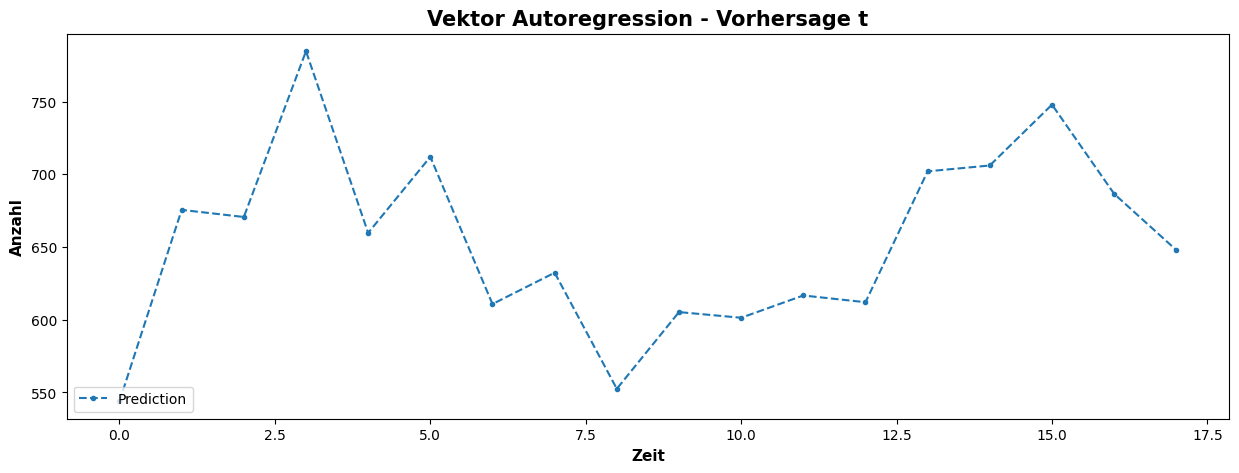

In [44]:
#plot_actual_vs_preds(test.iloc[:, 0], inverse_test.iloc[:, 0])

plt.figure(figsize=(15, 5))
plt.plot(inverse.iloc[:, 0], linestyle='dashed', label='Prediction', marker = '.')
plt.title('Vektor Autoregression - Vorhersage t', fontweight='bold', fontsize=15)
plt.xlabel('Zeit', fontsize=11, fontweight='bold')
plt.ylabel('Anzahl', fontsize=11, fontweight='bold')
plt.legend(loc='lower left')
#plt.xlim(0,100)
#plt.savefig(f'Forecast.png')
plt.show()

## VARMAX

In [45]:
# Fit a local level model
mod_var1 = sm.tsa.VARMAX(train_var_shifted, order=(7,0), enforce_stationarity=True)
# Note that mod_var1 is an instance of the VARMAX class

# Fit the model via maximum likelihood
res_var1 = mod_var1.fit(disp=False)
# Note that res_var1 is an instance of the VARMAXResults class


print(res_var1.summary())


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                                                                                                                                                                                                                Statespace Model Results                                                                                                                                                                                                                                
Dep. Variable:     ['sales_actuals_monthly__vehiclegroup01__orderintake', 'customer_vehicle_relationships__vehiclegroup01__active_cars', 'sales_actuals_monthly__vehiclegroup01__retail', 'sales_stock_monthly__vehiclegroup01__physical', 'sales_flow_monthly__vehiclegroup01__cp8', 'customer_vehicle_relationships__vehiclegroup01__terminated_cars', 'premises__vehiclegroup01__in_sales', 'sales_stock_monthly__vehiclegroup01__grossall']   No. Observations:                  239
Model:                                                

In [46]:
predict = res_var1.get_prediction(start=len(train_var_shifted), end=len(train_var_shifted)+len(test_var)-2)
predictions = predict.predicted_mean
#predictions.index = test_var.index
#predictions.columns = test_var.columns
#predictions = pd.concat([predictions, test], axis=1)
predictions

,sales_actuals_monthly__vehiclegroup01__orderintake,customer_vehicle_relationships__vehiclegroup01__active_cars,sales_actuals_monthly__vehiclegroup01__retail,sales_stock_monthly__vehiclegroup01__physical,sales_flow_monthly__vehiclegroup01__cp8,customer_vehicle_relationships__vehiclegroup01__terminated_cars,premises__vehiclegroup01__in_sales,sales_stock_monthly__vehiclegroup01__grossall
2020-01,113.028822,106.292914,164.512363,-28.122071,5.945445,79.617468,-19.174362,39.450607
2020-02,-17.404383,13.480848,-63.104708,-35.990785,52.101961,-43.195349,-2.496384,-18.892460
2020-03,81.350594,131.901130,247.382429,-42.797405,11.894457,63.693205,23.183205,-26.480292
2020-04,-84.900734,-43.973437,91.211792,-73.734731,34.826905,-20.337429,-79.022324,-98.989888
2020-05,-6.682191,-21.207551,-22.607820,-19.826830,-3.829776,16.844679,47.552968,-30.775703
2020-06,-115.385588,-49.290766,-80.077765,-4.203211,-22.454572,16.091453,42.034905,-17.478740
2020-07,48.441093,-40.752845,-6.377296,-12.286793,-59.248756,-18.334007,17.479796,-3.756611
2020-08,-91.215724,-55.352430,-256.967844,-39.437922,-92.359379,-27.512667,37.466884,-32.131957
2020-09,37.054875,26.774430,44.534142,46.925127,78.671265,0.813183,-0.756115,48.099983
2020-10,-3.115681,-36.580610,-36.816921,60.592389,-7.291398,-6.900273,3.836657,38.422036


In [47]:
inverse_test_varma = invert_differencing(test_var, predictions, num_observations)

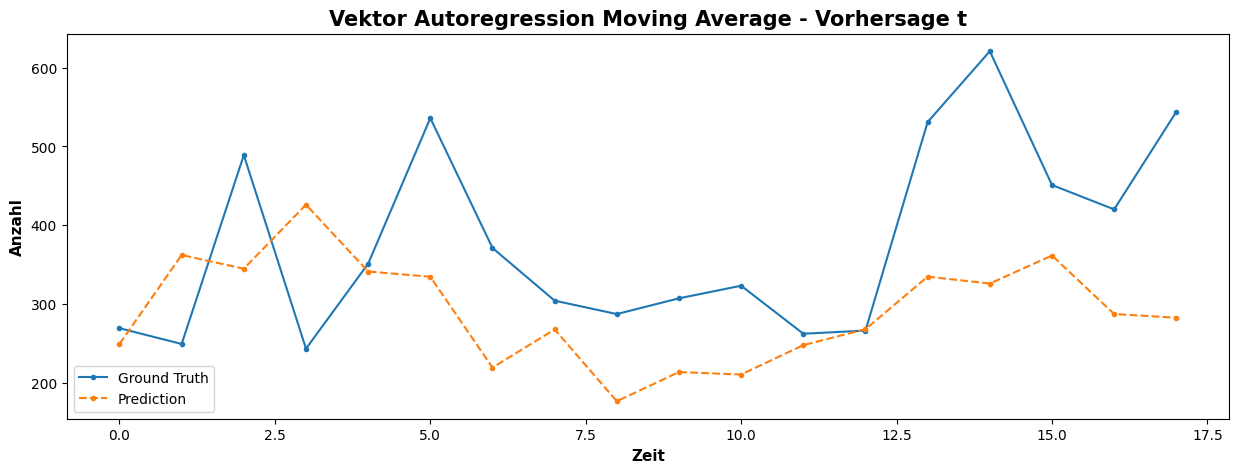

In [48]:
#plot_actual_vs_preds(test.iloc[:, 0], inverse_test.iloc[:, 0])

plt.figure(figsize=(15, 5))
plt.plot(test_plot.iloc[:, 0] ,label='Ground Truth', marker = '.')
plt.plot(inverse_test_varma.iloc[:, 0], linestyle='dashed', label='Prediction', marker = '.')
plt.title('Vektor Autoregression Moving Average - Vorhersage t', fontweight='bold', fontsize=15)
plt.xlabel('Zeit', fontsize=11, fontweight='bold')
plt.ylabel('Anzahl', fontsize=11, fontweight='bold')
plt.legend(loc='lower left')
#plt.xlim(0,100)
#plt.savefig(f'Forecast.png')
plt.show()

In [49]:
evaluate_prediction(actual=test_plot.iloc[:, 0], predictions=inverse_test.iloc[:, 0])

Mean Absolute Error: 80.45
Mean Absolute Percentage Error: 21.94%
Mean Squared Error: 11886.62
Root Mean Squared Error: 109.03


